In [0]:
# Import the corpus data

from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import pickle 

proj_dir = '/content/drive/My Drive/accent-classification-corpora/'

# SVM and MF

In [1]:
with open(os.path.join(proj_dir, 'flat_formants.pickle'), 'rb') as jar:
    formants_data = pickle.load(jar)

formants_targets = np.concatenate([np.zeros(958), np.ones(1111)])

In [0]:
from sklearn.model_selection import train_test_split

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    formants_data, formants_targets, test_size=0.20, random_state=42)

(1655, 1200)


In [0]:
from sklearn.svm import SVC
# SVM baseline
clf = SVC(gamma='auto')
clf.fit(X_train_svm, y_train_svm)

clf.score(X_train_svm, y_train_svm)

1.0

In [0]:
clf.score(X_test_svm, y_test_svm)

0.5507246376811594

In [0]:
from sklearn.dummy import DummyClassifier

uniform = DummyClassifier(strategy='most_frequent', random_state=42)
uniform.fit(X_train_svm, y_train_svm)

print(uniform.score(X_train_svm, y_train_svm))

print(uniform.score(X_test_svm, y_test_svm))

0.5335347432024169
0.5507246376811594


# RNN



In [0]:
import os 
import numpy as np

# Load sequential data from pickle
with open(os.path.join(proj_dir, 'seq_formants.pickle'), 'rb') as jar:
    formants_data = pickle.load(jar)

formant_targets = np.concatenate([np.zeros(958), np.ones(1111)])
print(formants_data.shape)
print(formant_targets.shape)

(2069, 400, 3)
(2069,)


In [0]:
# Split into training and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    formants_data, formant_targets, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)

(1655, 400, 3)
(1655,)


In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

Using TensorFlow backend.


(1655, 2)
(414, 2)


In [0]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, CSVLogger

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
      

In [0]:
import datetime

In [3]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.regularizers import l1_l2

# Set up early stopping callbacks and logging
log_filename = '{date:%Y-%m-%d_%H:%M:%S}.txt'.format(date=datetime.datetime.now())
formants_log_path = '/content/drive/My Drive/accent-classification-corpora/logging/formant/'
log_path = os.path.join(formants_log_path, log_filename)

# Hyperparameters, CHANGE AS NEEDED
num_lstm_units = 500
num_epochs = 10
batch_size = 100

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=os.path.join(proj_dir, 'formants_rnn2.h5'), monitor='val_loss', save_best_only=True),
             CSVLogger(log_path)]

# Structure the network
# CHANGE THIS AS NEEDED.
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=False),
                        input_shape=(400, 3)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))


#model.add(LSTM(500, return_sequences=False))

model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_split=0.10, shuffle=True, verbose=1,callbacks=callbacks)



In [2]:
from keras.models import load_model

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=2)
print ("Accuracy: %.2f%%" % (scores[1]*100))

# Append to log
line = 'num_lstm_units: {} \n num_epochs: {} \n batch_size: {}'.format(num_lstm_units, num_epochs, batch_size)
with open(log_path, 'a') as fp:
    fp.write('\n')
    fp.write(line)
    fp.write('\n')
    fp.write("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 86.96%


# Hyper params tune

In [0]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


# Set up early stopping callbacks and logging
log_filename = '{date:%Y-%m-%d_%H:%M:%S}.txt'.format(date=datetime.datetime.now())
formants_log_path = '/content/drive/My Drive/accent-classification-corpora/logging/formant/'
log_path = os.path.join(formants_log_path, log_filename)

# Hyperparameters, CHANGE AS NEEDED
num_lstm_units = 500
num_epochs = 10
batch_size = 100

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=os.path.join(proj_dir, 'formants_rnn2.h5'), monitor='val_loss', save_best_only=True),
             CSVLogger(log_path)]

# Structure the network
# CHANGE THIS AS NEEDED.
def create_model(hidden_units_LSTM):
    print("I m here",hidden_units_LSTM)
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_units_LSTM, return_sequences=False),
                          input_shape=(400, 3)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=100, verbose=1)
# define the grid search parameters
hidden_units_LSTM = [10,20,50,100,200]
param_grid = dict(hidden_units_LSTM=hidden_units_LSTM)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


I m here 10
I m here 10
Epoch 1/20
Epoch 1/20
1103/1103 [==============================] - 45s 41ms/step - loss: 0.6896 - acc: 0.5394
Epoch 2/20
1103/1103 [==============================] - 47s 42ms/step - loss: 0.6928 - acc: 0.5222
Epoch 2/20
1103/1103 [==============================] - 44s 40ms/step - loss: 0.6887 - acc: 0.5385
Epoch 3/20
1103/1103 [==============================] - 43s 39ms/step - loss: 0.6892 - acc: 0.5422
Epoch 3/20
1103/1103 [==============================] - 44s 39ms/step - loss: 0.6857 - acc: 0.5431
Epoch 4/20
1103/1103 [==============================] - 43s 39ms/step - loss: 0.6854 - acc: 0.5422
Epoch 4/20
1103/1103 [==============================] - 38s 34ms/step - loss: 0.6807 - acc: 0.5657
Epoch 5/20
1103/1103 [==============================] - 47s 43ms/step - loss: 0.6828 - acc: 0.5467
Epoch 5/20
1103/1103 [==============================] - 43s 39ms/step - loss: 0.6762 - acc: 0.5820
Epoch 6/20
1103/1103 [==============================] - 44s 40ms/step - lo

# End of hyper params tune

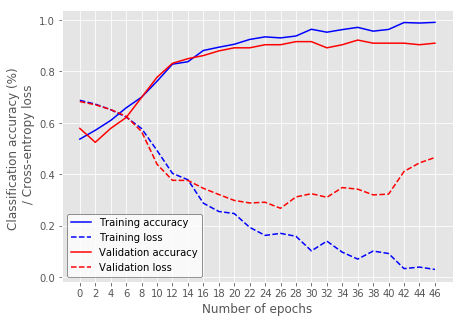

In [0]:
# Get plot of learning curves for best run
import os
formants_log_path = '/content/drive/My Drive/accent-classification-corpora/logging/formant/'

# Best run for the MFCC RNN is: 2018-11-22_13:17:22.txt
# You'll need to check the logs and replace this with the best formants run.

log_path = os.path.join(formants_log_path, '2018-12-07_17:06:08.txt')
with open(log_path, 'r') as fp:
    lines = fp.readlines()

# Just get the train/valid acc lines, not the hyperparam info at the bottom of the log  
lines = lines[:-5]

train_loss, train_acc = [], []
valid_loss, valid_acc = [], []
epochs = np.arange(0, 48, 2.0)
x = 0
for line in lines[1:]: # Skip the first header line
    if x == 0:
        split_line = line.split(',')
        train_acc.append(float(split_line[1]))
        train_loss.append(float(split_line[2]))
        valid_acc.append(float(split_line[3]))
        valid_loss.append(float(split_line[4]))
        x = 1
    else:
        x = 0
        
#Now plot
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (7,5)

plt.plot(epochs, train_acc, color='blue', linestyle='solid', label='Training accuracy')
plt.plot(epochs, train_loss, color='blue', linestyle='dashed', label='Training loss')

plt.plot(epochs, valid_acc, color='red', linestyle='solid', label='Validation accuracy')
plt.plot(epochs, valid_loss, color='red', linestyle='dashed', label='Validation loss')

plt.xlabel('Number of epochs')
plt.xticks(epochs)

plt.ylabel('Classification accuracy (%) \n / Cross-entropy loss')

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()